In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss
from scipy.optimize import minimize

In [2]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
def init_params(input_dim=2, hidden_dim=10, output_dim=1):
    params = {
        "W1": np.random.randn(input_dim, hidden_dim) * 0.1,
        "b1": np.zeros((1, hidden_dim)),
        "W2": np.random.randn(hidden_dim, output_dim) * 0.1,
        "b2": np.zeros((1, output_dim))
    }
    return params

In [4]:
def forward(X, params):
    z1 = X @ params["W1"] + params["b1"]
    a1 = np.tanh(z1)
    z2 = a1 @ params["W2"] + params["b2"]
    a2 = 1 / (1 + np.exp(-z2))  # sigmoid
    return a1, a2

def compute_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

def backward(X, y, a1, a2, params):
    m = len(y)
    dz2 = a2 - y.reshape(-1, 1)
    dW2 = (a1.T @ dz2) / m
    db2 = np.mean(dz2, axis=0, keepdims=True)

    da1 = dz2 @ params["W2"].T
    dz1 = da1 * (1 - a1**2)
    dW1 = (X.T @ dz1) / m
    db1 = np.mean(dz1, axis=0, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

In [5]:
def flatten_params(params):
    return np.concatenate([p.flatten() for p in [params["W1"], params["b1"], params["W2"], params["b2"]]])

def unflatten_params(vector, input_dim=2, hidden_dim=10, output_dim=1):
    s1 = input_dim * hidden_dim
    e1 = s1
    s2 = e1 + hidden_dim
    e2 = s2
    s3 = e2 + hidden_dim * output_dim
    e3 = s3
    s4 = e3 + output_dim
    W1 = vector[:s1].reshape(input_dim, hidden_dim)
    b1 = vector[s1:e1].reshape(1, hidden_dim)
    W2 = vector[e1:s2].reshape(hidden_dim, output_dim)
    b2 = vector[s2:s3].reshape(1, output_dim)
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [6]:
def sgd(params, grads, lr=0.1):
    for k in params:
        params[k] -= lr * grads["d" + k]
    return params

def momentum(params, grads, velocity, lr=0.1, beta=0.9):
    for k in params:
        velocity[k] = beta * velocity[k] + (1 - beta) * grads["d" + k]
        params[k] -= lr * velocity[k]
    return params, velocity

def adam(params, grads, m, v, t, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
    for k in params:
        m[k] = beta1 * m[k] + (1 - beta1) * grads["d" + k]
        v[k] = beta2 * v[k] + (1 - beta2) * (grads["d" + k] ** 2)
        m_hat = m[k] / (1 - beta1 ** t)
        v_hat = v[k] / (1 - beta2 ** t)
        params[k] -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return params, m, v

In [7]:
def train(optimizer="sgd", epochs=100, lr=0.1):
    params = init_params()
    trajectory = []
    velocity = {k: np.zeros_like(v) for k, v in params.items()}
    m = {k: np.zeros_like(v) for k, v in params.items()}
    v = {k: np.zeros_like(v) for k, v in params.items()}
    losses, accs = [], []

    for t in range(1, epochs + 1):
        a1, y_pred = forward(X_train, params)
        loss = compute_loss(y_train, y_pred)
        grads = backward(X_train, y_train, a1, y_pred, params)

        if optimizer == "sgd":
            params = sgd(params, grads, lr)
        elif optimizer == "momentum":
            params, velocity = momentum(params, grads, velocity, lr)
        elif optimizer == "adam":
            params, m, v = adam(params, grads, m, v, t, lr)

        trajectory.append(flatten_params(params))
        losses.append(loss)

        y_hat = (y_pred > 0.5).astype(int)
        acc = accuracy_score(y_train, y_hat)
        accs.append(acc)

    return np.array(trajectory), losses, accs, params

In [8]:
results = {}
for opt in ["sgd", "momentum", "adam"]:
    print(f"Training with {opt.upper()}...")
    traj, losses, accs, params = train(optimizer=opt, epochs=200, lr=0.1 if opt!="adam" else 0.01)
    results[opt] = {"traj": traj, "loss": losses, "acc": accs}

Training with SGD...
Training with MOMENTUM...
Training with ADAM...


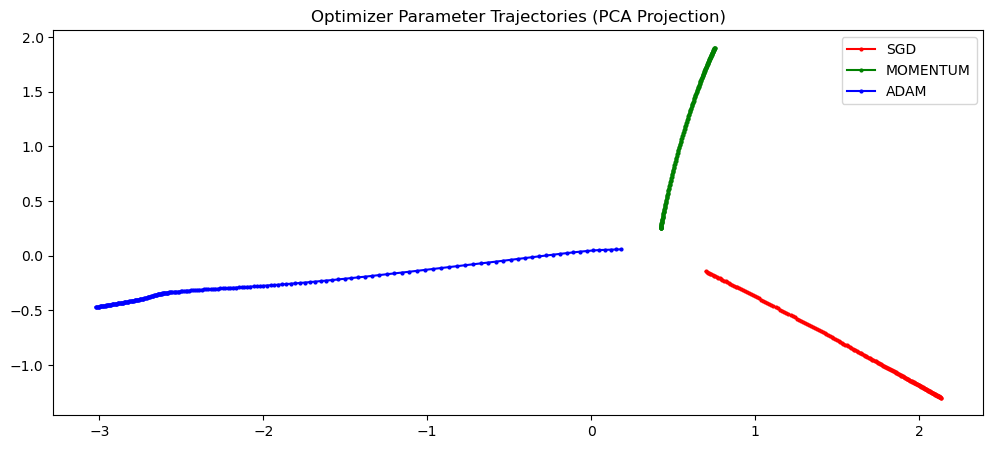

In [9]:
all_traj = np.concatenate([results[o]["traj"] for o in results], axis=0)
pca = PCA(n_components=2)
pca.fit(all_traj)

plt.figure(figsize=(12, 5))
for opt, color in zip(results.keys(), ["r", "g", "b"]):
    proj = pca.transform(results[opt]["traj"])
    plt.plot(proj[:,0], proj[:,1], marker="o", markersize=2, color=color, label=opt.upper())
plt.title("Optimizer Parameter Trajectories (PCA Projection)")
plt.legend()
plt.show()

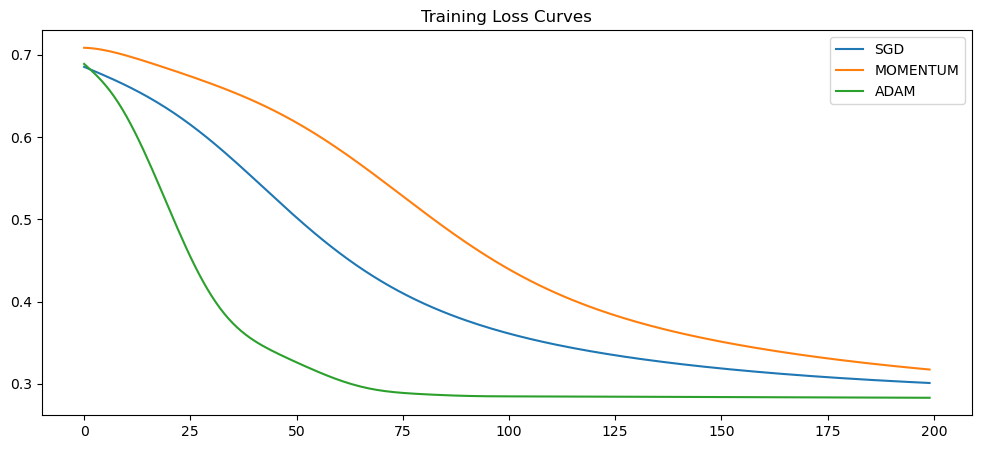

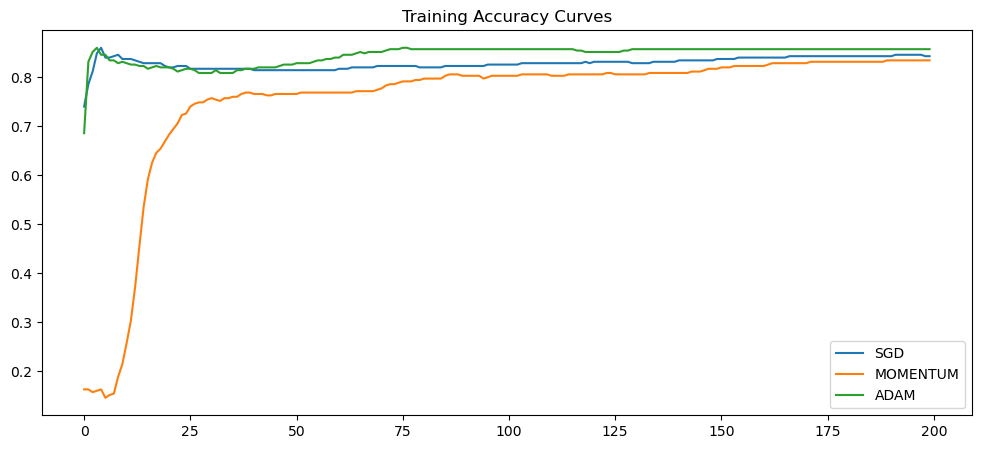

In [10]:
plt.figure(figsize=(12, 5))
for opt in results:
    plt.plot(results[opt]["loss"], label=opt.upper())
plt.title("Training Loss Curves")
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(12, 5))
for opt in results:
    plt.plot(results[opt]["acc"], label=opt.upper())
plt.title("Training Accuracy Curves")
plt.legend()
plt.show()